**Purpose:**
Is there any common YOE pattern between software Engineer titles and common and different job titles that comes under the hierarchy of software engineering.

**Objective:**

Learn how the minimum years of experience (parsed from BG) relate to common job levels for Software jobs (junior, mid-level, senior, etc.).

**Executive Summary:**

We conducted this study for one title in the earlier work Seniority Signals of Java Developer job title. The same kind of work is carried out on some popular job titles, including Python, C#, Software, ServiceNow, and SalesForce, to determine the minimum years of experience (parsed from BG) required for a job description. In order to observe uniqueness and distributional patterns, we chose titles from the hierarchy of software development (Java, Python, C#, Software, ServiceNow) and one different title (ServiceNow). The distribution of junior-level tags is identical, but when we get to the higher level, we observe differences. In contrast to software, Java senior tags have slightly more experience than other job titles. The titles without seniority tags vary depending on the title, although they often fall between midlevel and senior level. The majority of job titles have a distribution that is similar to level 3. We determined the minimum and maximum number of years of experience for each title based on the seniority criterion.

In [2]:
import warnings#must remove 
warnings.filterwarnings('ignore')

import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from IPython.display import HTML
from matplotlib.lines import Line2D
from itertools import combinations
from itertools import permutations
from scipy import stats


from dhi.dsmatch import local_bucket
from dhi.dsmatch.sklearnmodeling.models.applytransformer import ApplyTransformer
from dhi.dsmatch.sklearnmodeling.functiontransformermapper import applymap
from dhi.dsmatch.util.io import read_csv

# Loading the data generated from [notebook](https://sfurti-srivastava-experiments.notebook.us-east-1.sagemaker.aws/notebooks/sfurti/dhi-match-dice-research/notebooks/v2/MATCH-2865-deep-dive-comparison-on-software-%20engineering-role-for-seniority/seniority-tags_with-multiple-titles.ipynb)

In [3]:
java =pd.read_csv(os.path.join(local_bucket,'data','dice','research','seniority',f'java_bg806_exp_extracted_data_with_tags.csv'))
python =pd.read_csv(os.path.join(local_bucket,'data','dice','research','seniority','python_bg806_exp_extracted_data_with_tags.csv'))
csharp  = pd.read_csv(os.path.join(local_bucket,'data','dice','research','seniority','c_bg806_exp_extracted_data_with_tags.csv'))
software = pd.read_csv(os.path.join(local_bucket,'data','dice','research','seniority','software_bg806_exp_extracted_data_with_tags.csv'))
servicenow = pd.read_csv(os.path.join(local_bucket,'data','dice','research','seniority','servicenow_bg806_exp_extracted_data_with_tags.csv'))
salesforce = pd.read_csv(os.path.join(local_bucket,'data','dice','research','seniority','salesforce_bg806_exp_extracted_data_with_tags.csv'))

# Collecting all tags found under differnt titles

In [4]:


tags = []
for x in [java, python,csharp,software,servicenow,salesforce]:
    x = pd.DataFrame(x['seniority_tags'].value_counts()).reset_index()['index'].to_list()
    tags.append(x)
alltags = list(set(chain(*tags)))


# Removing the tags from each dataset where count is less than 20

The less records influence the KS test score, that is why we are removing those tags.

In [5]:
def rem_less_freq_tags(df):   
    v = df.seniority_tags.value_counts()
    print('Before data size:', df.shape[0])
    df = df[df.seniority_tags.isin(v.index[v.gt(20)])].reset_index(drop=True)
    print('After data size:', df.shape[0])
    print('----------')
    return df
java = rem_less_freq_tags(java)
python = rem_less_freq_tags(python)
csharp = rem_less_freq_tags(csharp)
software = rem_less_freq_tags(software)
servicenow = rem_less_freq_tags(servicenow)
salesforce = rem_less_freq_tags(salesforce)

Before data size: 53591
After data size: 53520
----------
Before data size: 11295
After data size: 11199
----------
Before data size: 5140
After data size: 5085
----------
Before data size: 25658
After data size: 25619
----------
Before data size: 3268
After data size: 3208
----------
Before data size: 13419
After data size: 13346
----------


In [6]:
df = pd.DataFrame(alltags).rename(columns={0:'tags'})


# Do different seniority levels of this title/role have statistically different min. years of experience distributions?
- Yes, other than junior tag all the distributions are different.

With the KS-test([Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)), we compared the titles' tags (Java, Python, C#, ServiceNow, SalesForce) with the Software Engineer. The KS test results with the software developer are represented by the scatter graphs below. Zero is expressing the exact same distribution, whereas as we move up, the distribution varies. The tags shown in the graph are present in all the titles. Y-axis is the KS-test score and the x-axis is seniority tags, the color dots inside is representing the titles. We can see there are dissimilarity  between the distribution of titles. Except for junior, Java distribution differs the most from all the other job titles.

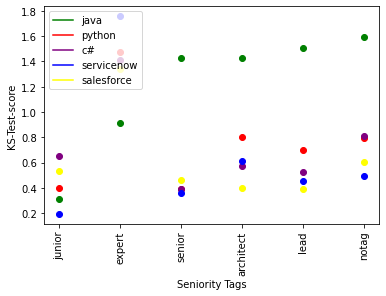

In [7]:
def ks_test_score(data_): 
    ks_test = []
    for s in alltags:  
        bins = np.arange(-.5, 16.5)
        h_notag, _ = np.histogram(software['overall_experience_job'][(software['seniority_tags']==s)], density=True, bins=bins)
        h_s, _ = np.histogram(data_['overall_experience_job'][(data_['seniority_tags']==s)], density=True, bins=bins)
    #     ab = np.abs(h_notag-h_s).sum()
        ks = np.abs(h_notag.cumsum()-h_s.cumsum()).sum()

    #     abs_diff.append(ab) 
        ks_test.append(ks) 
    return ks_test
for data,col in zip([java, python,csharp,servicenow, salesforce],['java','python','c#','servicenow','salesforce']):
    df[f'{col}_ks_test'] = ks_test_score(data)
df_ = df.dropna()#subset=['java_ks_test', 'python_ks_test', 'c#_ks_test','salesforce_ks_test' ])
df_ = df_.sort_values('java_ks_test')
fig, ax= plt.subplots()    
ax.scatter(df_['tags'], df_['java_ks_test'], color='green')
ax.scatter(df_['tags'], df_['python_ks_test'], color='red')
ax.scatter(df_['tags'], df_['c#_ks_test'], color='purple')
ax.scatter(df_['tags'], df_['servicenow_ks_test'], color='blue')
ax.scatter(df_['tags'], df_['salesforce_ks_test'], color='yellow')
ax.set_xticklabels(df_['tags'], rotation = 90)
ax.set_ylabel('KS-Test-score')
ax.set_xlabel('Seniority Tags')
legend_elements = [
                  Line2D([0], [0], color='green', label='java'),
                  Line2D([0], [0], color='red', label='python'),
                  Line2D([0], [0], color='purple', label='c#'),
                  Line2D([0], [0], color='blue', label='servicenow'),
                  Line2D([0], [0], color='yellow', label='salesforce')]
ax.legend(handles=legend_elements, loc='upper left');


The data below is the similarity scores from software to other title which is represing the KS test scores for each title with software engineer, on same tag. lets say junior tag of Java developer is quite similar with software debeloper junior tag.

In [8]:
df.sort_values(['java_ks_test','python_ks_test', 'c#_ks_test','salesforce_ks_test'])


,tags,java_ks_test,python_ks_test,c#_ks_test,servicenow_ks_test,salesforce_ks_test
31,junior,0.308776,0.401219,0.649007,0.194172,0.533473
15,level 3,0.315493,0.400685,0.734589,NaN,0.642922
5,associate,0.487036,0.740988,NaN,NaN,NaN
26,principal,0.501493,1.459678,NaN,NaN,1.407058
21,level 4,0.622802,NaN,NaN,NaN,NaN
11,level 1,0.710521,NaN,NaN,NaN,NaN
6,level 2,0.715653,0.420327,0.576881,NaN,0.749294
19,staff,0.716563,NaN,NaN,NaN,NaN
10,midlevel,0.811534,0.436968,0.573904,NaN,0.395441
9,expert,0.913962,1.474801,1.411703,1.758621,1.339857


Here we are plotting the each title distribution for perticulat tag to see the similarity. We compared the distribution of seniority tags and discovered that, apart from junior, all tags are dissimilar from one another, below graph depicts the same.

In [9]:
def similarity_distribition(tag):  
    display(HTML(f'<b>Tag: {tag}<b>'))
    bins = np.arange(-.5, 16.5)
    fig, ax=plt.subplots()
    fig, ax1=plt.subplots()
    for data,col,colors in zip([software,java, python,csharp,servicenow, salesforce],[
        'software','java','python','c#','servicenow','salesforce'],[
        'blue','green','red','purple','orange','yellow']):
#         med = data['overall_experience_job'][(data['seniority_tags']==tag)].median()
#         display(HTML(f'<b>{col} Median: {med}<b>'))
        h_notag, _ = np.histogram(data['overall_experience_job'][(data['seniority_tags']==tag)], density=True, bins=bins)
        # h_s, _ = np.histogram(python['overall_experience_job'][(python['seniority_tags']=='senior')], density=True, bins=bins)
        ax.plot(h_notag.cumsum(), color=colors)
        ax1.hist(data['overall_experience_job'][(data['seniority_tags']==tag)], color=colors, density=True, bins=bins, alpha=0.2)
        legend_elements = [Line2D([0], [0], color='blue',  label='software'),
                          Line2D([0], [0], color='green', label='java'),
                          Line2D([0], [0], color='red', label='python'),
                          Line2D([0], [0], color='purple', label='c#'),
                          Line2D([0], [0], color='orange', label='servicenow'),
                          Line2D([0], [0], color='yellow', label='salesforce')
                          ]
    ax.legend(handles=legend_elements, loc='lower right')
    ax1.legend(handles=legend_elements, loc='upper right')
    for axy in [ax,ax1]:
        axy.set_xlabel('Years of experience')
    plt.show()


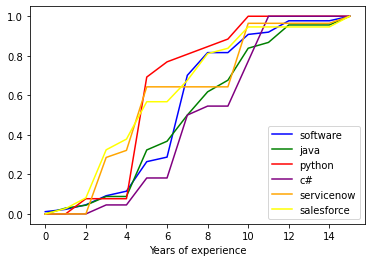

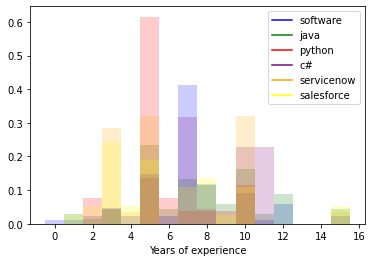

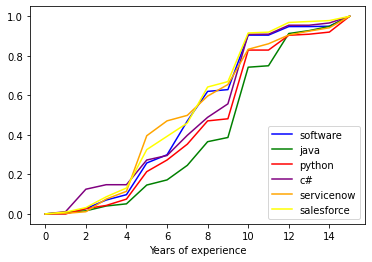

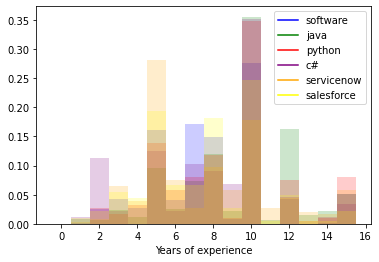

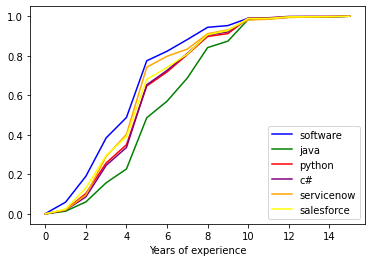

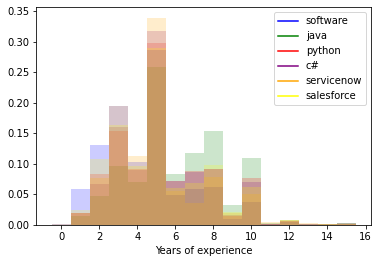

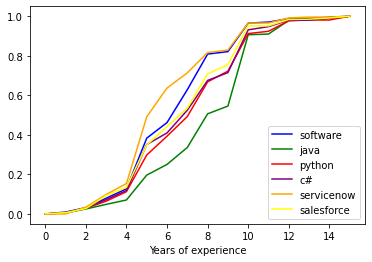

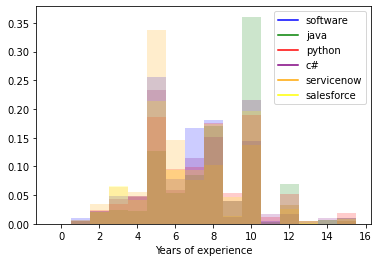

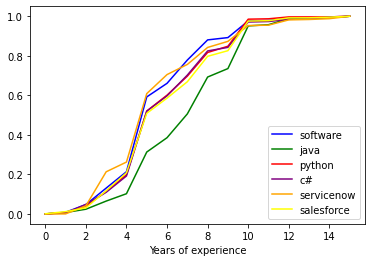

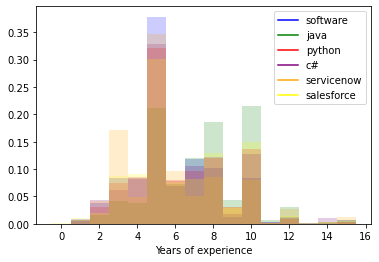

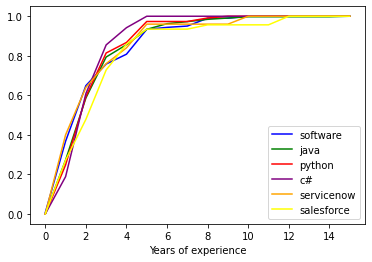

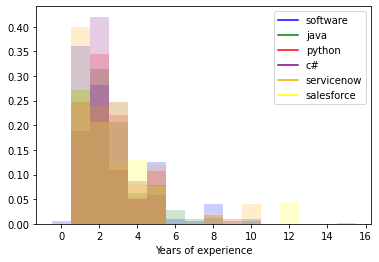

In [10]:
for t in df.dropna()['tags'].to_list():
    similarity_distribition(t)

# most similar tag

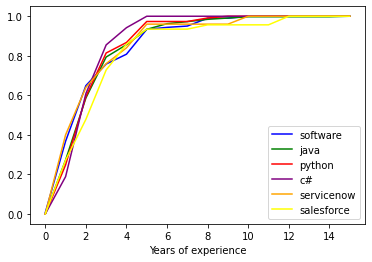

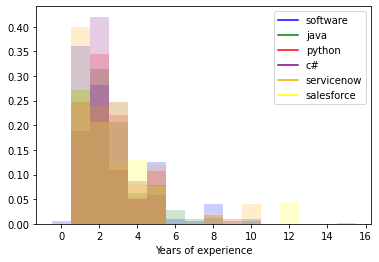

In [11]:
similarity_distribition('junior')

# with notag

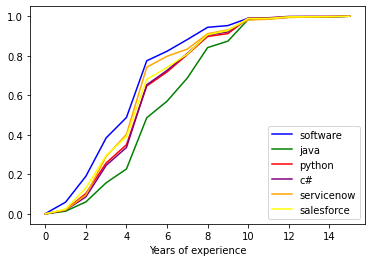

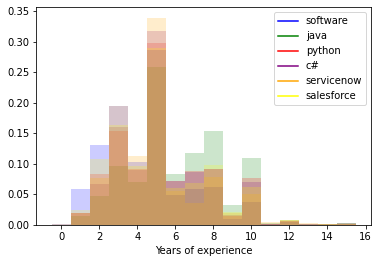

In [12]:
print("    ")
similarity_distribition('notag')

# [Paired T-test](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/sas/sas4-onesamplettest/SAS4-OneSampleTtest7.html#:~:text=A%20paired%20t%2Dtest%20is,in%201962%20for%20each%20subject.)
Another approch to find the similarity between titles seniority tags.When you want to check how different samples from the same group are, you can go for a paired T-test. The lower the p-value, the lower the probability of obtaining a result. This is almost same as the above ktest.

In [13]:
from scipy import stats

def sample_size(data1,data2, stag):
    """Calculating the sample size finding the shape of
    both dataset and choose the smallest dataset size as
    the sample size of perticular comparision."""
    df1 = data1[data1['seniority_tags']==stag]
    df2 = data2[data2['seniority_tags']==stag]
    if df1.shape[0]> df2.shape[0]:
        return df2.shape[0]
    else:
        return df1.shape[0]


def calc_pval(d1, d2, stag):
    """ Get random sample of the biggest dataset of sample size"""
    sam_size = sample_size(d1,d2, stag)

    dd1 = d1[['overall_experience_job']][d1['seniority_tags']==stag].sample(n=sam_size, random_state=123).reset_index(drop=True)
    dd2 = d2[['overall_experience_job']][d2['seniority_tags']==stag].sample(n=sam_size, random_state=123).reset_index(drop=True)
    pval = stats.ttest_rel(a=dd1, b=dd2)
    return pval[1][0]


def datasetbuild_with_pval(s_tag):
    """Do a Ttest for two sample data titles of same tag """
    d_ = {}
    comp1 = []
    comp2 = []
    pvalue = []

    perm = permutations([java, python, software, salesforce, servicenow, csharp], 2)
    perm1 = permutations(['java', 'python', 'software', 'salesforce', 'servicenow', 'csharp'], 2)
    for i,j in zip(list(perm),list(perm1) ):

        pval = calc_pval(i[0], i[1], s_tag)
        comp1.append(j[0])
        comp2.append(j[1])
        pvalue.append(pval)
    d_['s_tag'] = s_tag
    d_['comp1'] = comp1
    d_['comp2'] = comp2
    d_['pvalue'] = pvalue
    d_ = pd.DataFrame(d_)
    d_['comp'] = d_['comp1']+'-'+d_['comp2'] 
    return d_[['s_tag', 'comp', 'pvalue']]

datasetbuild_with_pval('junior')
tags = df['tags'].to_list()
df_ = datasetbuild_with_pval(tags[0])
for t in tags[1:]:
    df1_ = datasetbuild_with_pval(t)
    df_ = pd.concat([df_,df1_], axis=0)
df_ = df_.reset_index(drop=True)
df_ = df_.dropna(subset= 'pvalue')

df_

,s_tag,comp,pvalue
150,associate,java-python,0.147428
151,associate,java-software,0.441349
155,associate,python-java,0.147428
156,associate,python-software,0.432430
160,associate,software-java,0.441349
...,...,...,...
955,junior,csharp-java,0.392581
956,junior,csharp-python,0.364213
957,junior,csharp-software,0.098703
958,junior,csharp-salesforce,0.018546


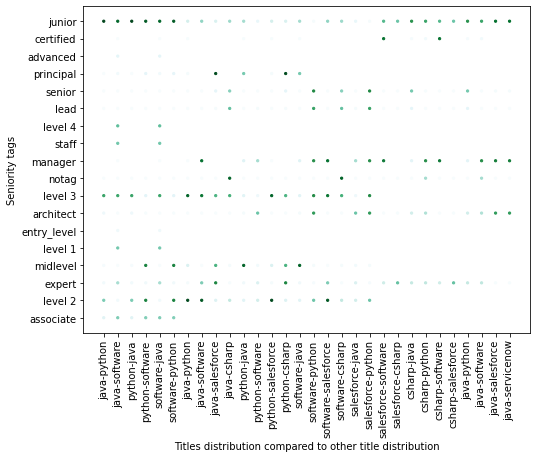

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
fig, ax=plt.subplots(figsize=(8, 6))

ax.scatter( df_['comp'],df_['s_tag'], c=df_['pvalue'],  s=5, cmap='BuGn')
ax.set_xticklabels(df_['comp'], rotation = 90)
ax.set_ylabel('Seniority tags')
ax.set_xlabel('Titles distribution compared to other title distribution');


# What 50 percentile of the years of experince says for particular tags on each titles.
In the below table we can see that all the experince on tags for titles.50% of the data says the different experience for the same tag of a different title, for example, senior of java, ask for 7 or less experience where senior software engineer asks for 5 or less experience :

In [15]:
def median_value(data,df_name):
    tags = df['tags'].to_list()
    d = {}
    med = []
    for t in tags:
        m = data['overall_experience_job'][(data['seniority_tags']==t)].median()
        med.append(m)
    d['tags'] = tags
    d[f'{df_name}_med_exp'] = med
    d = pd.DataFrame(d)
    return d
j = median_value(java, 'java')  
p = median_value(python, 'python')
c = median_value(csharp, 'csharp')
s = median_value(software, 'software')
sl = median_value(salesforce, 'salesforce')
sn = median_value(servicenow, 'servicenow')

d = j.merge(p,on='tags').merge(c,on='tags').merge(s,on='tags').merge(s,on='tags').merge(sl,on='tags').merge(sn,on='tags')
d.dropna()



,tags,java_med_exp,python_med_exp,csharp_med_exp,software_med_exp_x,software_med_exp_y,salesforce_med_exp,servicenow_med_exp
9,expert,7.5,5.0,7.5,7.0,7.0,5.0,5.0
14,architect,10.0,10.0,9.0,8.0,8.0,8.0,8.0
16,notag,6.0,5.0,5.0,5.0,5.0,5.0,5.0
22,lead,8.0,8.0,7.0,7.0,7.0,7.0,6.0
25,senior,7.0,5.0,5.0,5.0,5.0,5.0,5.0
31,junior,2.0,2.0,2.0,2.0,2.0,3.0,2.0


# Does the min. years of experience distribution for titles with no seniority level appear similar to the distribution for a known seniority level (e.g. mid)?


We did this comparison for all the above titles to their other tags and titles found no seniority tags. We used again Kolmogorov–Smirnov(KS-test) for comparison, software, and salesforce distribution are closer to level 2, java, python, and Csharp closer to level 3, and service now to senior tag. The reason for ServiceNow to get the highest similarity KS score to senior is because of fewer data and it has only 8 tags where level 2, level 3. and midlevel do not exist. The titles with no seniority level lie somewhere between the mid-level tag and senior tag.  The table below presents the titles, their top 5 similar tags, and their KS-test score, we are considering the similarity the same if the score is less than 1.

In [16]:
def comparing_distr(data_,ti):
    bins = np.arange(-.5, 16.5)
    h_notag, _ = np.histogram(data_['overall_experience_job'][(data_['seniority_tags']=='notag')], density=True, bins=bins)
    s_tags = [ x for x in pd.DataFrame(data_['seniority_tags'].value_counts()).reset_index()['index'].to_list() if x!='notag']
    d = {}
    ks_score = []
    for s in s_tags:
        h_s, _ = np.histogram(data_['overall_experience_job'][(data_['seniority_tags']==s)], density=True, bins=bins)
        #     ab = np.abs(h_notag-h_s).sum()
        ks = np.abs(h_notag.cumsum()-h_s.cumsum()).sum()
        ks_score.append(ks)
    d['title']= ti
    d['tags'] = s_tags
    d['ks_score'] = ks_score
    d = pd.DataFrame(d)
    d = d[d['ks_score']<1]
    d = d.sort_values('ks_score').reset_index(drop = True)
    display(HTML(f'{d.to_html()}'))


comparing_distr(software,'software')
comparing_distr(java,'java')
comparing_distr(python,'python')
comparing_distr(csharp, 'csharp')
comparing_distr(salesforce, 'salesforce')
comparing_distr(servicenow, 'servicenow')


,title,tags,ks_score
0,software,level 2,0.559706
1,software,professional,0.611046
2,software,level 1,0.619281
3,software,certified,0.678551
4,software,level 3,0.930458


,title,tags,ks_score
0,java,level 3,0.653721
1,java,advanced,0.664096
2,java,certified,0.670455


,title,tags,ks_score
0,python,level 3,0.144139
1,python,expert,0.703446
2,python,senior,0.885151


,title,tags,ks_score
0,csharp,level 3,0.651445
1,csharp,senior,0.933821


,title,tags,ks_score
0,salesforce,level 2,0.410418
1,salesforce,level 3,0.592457
2,salesforce,certified,0.688831
3,salesforce,manager,0.892815
4,salesforce,expert,0.941373


,title,tags,ks_score
0,servicenow,senior,0.818165


# Finding thresholds for each tag as min-max experience:

We have collected some minimum and maximum years of experience by calculating 1 standard deviation and 2 standard deviations on the mean of each side. We followed the empirical rule to set the upper and lower control limits, the below example is explaining the same, the data is of senior software developer/engineer, for 1std we are capturing 68% of the data, and for 2STD 95% of the data. We have seen many incorrect parsing from BG causing outliers and chances of picking negative values on the left side of the mean, 1-std looks better to use. The x-axis is years of experience, the blue dotted line is the mean, and the black dotted lines are standard deviation +- on the mean. 

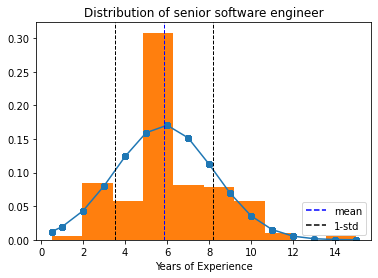

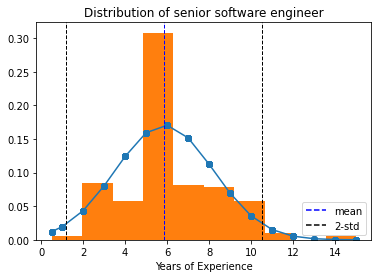

In [17]:
import numpy as np
import scipy.stats as stats
import pylab as pl
import statistics
def graph_std(data,st,tag, text):

    h = sorted(data['overall_experience_job'][(data['seniority_tags']==tag)])
    fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

    pl.plot(h,fit,'-o')

    pl.hist(h, density=True)      #use this to draw histogram of your data
    pl.axvline((np.mean(h)+(np.std(h)*st)), color='k', linestyle='dashed', linewidth=1)
    pl.axvline((np.mean(h)-(np.std(h)*st)), color='k', linestyle='dashed', linewidth=1)
    pl.axvline(np.mean(h), color='b', linestyle='dashed', linewidth=1)
    pl.xlabel('Years of Experience')
    pl.title(f'Distribution of {text}')
    legend_elements = [Line2D([0], [0], color='blue', linestyle='dashed', label='mean'),
                          Line2D([0], [0], color='black',linestyle='dashed', label=f'{str(st)}-std')
                          ]
    pl.legend(handles=legend_elements, loc='lower right')
    pl.show()                   #use may also need add this 
graph_std(software,1,'senior', 'senior software engineer')
graph_std(software,2,'senior', 'senior software engineer')

There can be some negative value on the left side which we are converting into zero for example below the graph is for Junior Java engineers. The chances of getting any negative values are very less in the case of 1STD :

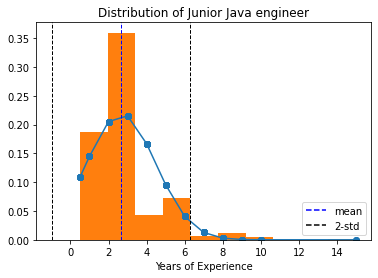

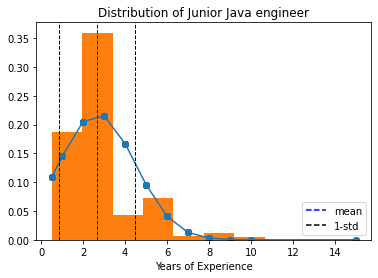

In [18]:
graph_std(java,2,'junior', 'Junior Java engineer')
graph_std(java,1,'junior', 'Junior Java engineer')

# Applying emperical rule(or 3sigma rule) for finding the upper and lower bound of each tag of each title.

For doing this we need to convert the non normal distribution into normal distribution. For this process we used two statistical approach boxcox and yeojohnson. After converting the data into normal distribution, we calculate its mean and STD and any value less than -STD and anything above +STD we will throw away. The min and max value of the data will be our lower and upper bound for that title tag. We are rounding off the values to the 1 digit "looking for 4.89 years of experince"


In [19]:
def make_thresholds(row, plus_1_mean, minus_1_mean):
    if minus_1_mean <= row <= plus_1_mean:
        return True
    else:
        return False
def select_subset(data, num):
    length = len(data)
    if length % 2 != 0:
        middle_value_index = round(length/2)
    else:
        middle_value_index = ((length/2) + ((length/2) + 1))/ 2
    quarter1 = middle_value_index - round(num*middle_value_index)
    quarter3 = middle_value_index + round(num*middle_value_index)
    df = data.sort_values('overall_experience_job').reset_index().loc[quarter1:quarter3+1, ['overall_experience_job', 'index']]
    return df

def remove_bad_data(data, num, method):
    df = select_subset(data, num)
    while df['overall_experience_job'].nunique() <= 1:
        num = num + .025
        df = select_subset(data, num)
    if method == 'boxcox':
        df['boxcox'] = stats.boxcox(df['overall_experience_job'])[0]
    elif method == 'yeojohnson':
        df['yeojohnson'] = stats.yeojohnson(df['overall_experience_job'])[0]
    return df

In [20]:
def cal_min_max(data,st, name,method):    
    d_={}
    minimum = []
    maximum = []
    tags = df['tags'].to_list()
    for s_tag in tags: 
        d = data[['overall_experience_job']][(data['seniority_tags']==s_tag)]
          
        if len(d)>0:
            sample = remove_bad_data(d, .34, method)

            plus_1_mean = np.mean(sample[method])+(np.std(sample[method])*st)
            minus_1_mean = np.mean(sample[method])-(np.std(sample[method])*st)

            sample['fit'] = sample[method].apply(lambda x: make_thresholds(x,plus_1_mean, minus_1_mean))
            mini = sample[sample['fit']==True]['overall_experience_job'].min()
            maxi = sample[sample['fit']==True]['overall_experience_job'].max()
            minimum.append(round(mini,1))
            maximum.append(round(maxi,1))
        else:
            minimum.append(np.nan)
            maximum.append(np.nan)
    d_['tags'] = df['tags']
    d_[f'{name}_min'] = minimum
    d_[f'{name}_max'] = maximum
    d_ = pd.DataFrame(d_)
    d_ = d_.sort_values(f'{name}_max' ,ascending = True ).reset_index(drop=True)
    d_[f'{name}_range'] = d_[f'{name}_min'].astype(str)+ ' - ' +d_[f'{name}_max'].astype(str)
    d_[f'{name}_range']  = d_[f'{name}_range'].str.replace('nan - nan', '')

    d_ = d_[['tags',f'{name}_range']]
    return d_
method ='yeojohnson'
st = 3
j = cal_min_max(java, st,'java',method)  
p = cal_min_max(python, st, 'python',method)
c = cal_min_max(csharp, st, 'csharp',method)
s = cal_min_max(software,st, 'software', method)
sl = cal_min_max(salesforce, st, 'salesforce',method)
sn = cal_min_max(servicenow,st, 'servicenow', method)
display(HTML(f'<b>Experince range {st}-STD by {method}</b>'))
d = s.merge(j,on='tags').merge(c,on='tags').merge(p,on='tags').merge(sl,on='tags').merge(sn,on='tags')
d = d[(d['software_range']!='') | (d['java_range']!='') | (
    d['csharp_range']!='')| (d['python_range']!='')| (
    d['salesforce_range']!='')| (d['servicenow_range']!='')]
d 


,tags,software_range,java_range,csharp_range,python_range,salesforce_range,servicenow_range
0,entry_level,2.0 - 2.0,1.0 - 2.0,,,,
1,junior,1.0 - 3.0,2.0 - 3.0,2.0 - 3.0,2.0 - 3.0,2.0 - 3.0,1.0 - 3.0
2,midlevel,3.0 - 4.0,3.0 - 5.0,2.0 - 3.0,3.0 - 5.0,3.0 - 4.0,
3,professional,2.0 - 5.0,,,,,
4,associate,2.0 - 5.0,3.0 - 5.0,,3.0 - 3.0,,
5,level 2,3.0 - 5.0,3.0 - 5.0,4.0 - 5.0,3.0 - 4.0,4.0 - 5.0,
6,notag,3.0 - 5.0,5.0 - 7.0,5.0 - 5.0,4.0 - 6.0,4.0 - 5.0,4.0 - 5.0
7,certified,2.0 - 5.0,5.0 - 8.0,,,4.0 - 7.0,5.0 - 8.0
8,level 1,3.0 - 5.0,3.0 - 6.0,,,,
9,level 3,5.0 - 6.0,5.0 - 6.0,4.0 - 6.0,5.0 - 6.0,5.0 - 5.0,


In [21]:
method ='boxcox'
st = 3
j = cal_min_max(java, st,'java',method)  
p = cal_min_max(python, st, 'python',method)
c = cal_min_max(csharp, st, 'csharp',method)
s = cal_min_max(software,st, 'software', method)
sl = cal_min_max(salesforce, st, 'salesforce',method)
sn = cal_min_max(servicenow,st, 'servicenow', method)
display(HTML(f'<b>Experince range {st}-STD by {method}</b>'))
d = s.merge(j,on='tags').merge(c,on='tags').merge(p,on='tags').merge(sl,on='tags').merge(sn,on='tags')
d = d[(d['software_range']!='') | (d['java_range']!='') | (
    d['csharp_range']!='')| (d['python_range']!='')| (
    d['salesforce_range']!='')| (d['servicenow_range']!='')]
d 

,tags,software_range,java_range,csharp_range,python_range,salesforce_range,servicenow_range
0,entry_level,2.0 - 2.0,1.0 - 2.0,,,,
1,junior,1.0 - 3.0,2.0 - 3.0,2.0 - 3.0,2.0 - 3.0,2.0 - 3.0,1.0 - 3.0
2,midlevel,3.0 - 4.0,3.0 - 5.0,2.0 - 3.0,3.0 - 5.0,3.0 - 4.0,
3,professional,2.0 - 5.0,,,,,
4,associate,2.0 - 5.0,3.0 - 5.0,,3.0 - 3.0,,
5,level 2,3.0 - 5.0,3.0 - 5.0,4.0 - 5.0,3.0 - 4.0,4.0 - 5.0,
6,notag,3.0 - 5.0,5.0 - 7.0,5.0 - 5.0,4.0 - 6.0,4.0 - 5.0,4.0 - 5.0
7,certified,2.0 - 5.0,5.0 - 8.0,,,4.0 - 7.0,5.0 - 8.0
8,level 1,3.0 - 5.0,3.0 - 6.0,,,,
9,level 3,5.0 - 6.0,5.0 - 6.0,4.0 - 6.0,5.0 - 6.0,5.0 - 5.0,


# Example for min -max thresholds

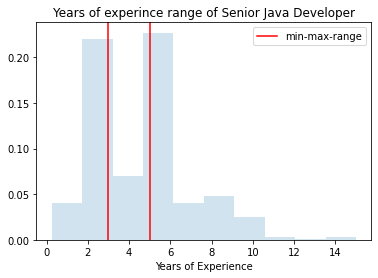

In [27]:
fig, ax=plt.subplots()
st=3
data = software
method = 'boxcox'
d = data[['overall_experience_job']][(data['seniority_tags']=='notag')]
ax.hist(d['overall_experience_job'], alpha=0.2, density=True)
sample = remove_bad_data(d, .34, method)
# ax.hist(sample.set_index('index')['boxcox'], alpha=0.2, density=True)
plus_1_mean = np.mean(sample[method])+(np.std(sample[method])*st)
minus_1_mean = np.mean(sample[method])-(np.std(sample[method])*st)

sample['fit'] = sample[method].apply(lambda x: make_thresholds(x,plus_1_mean, minus_1_mean))
mini = sample[sample['fit']==True]['overall_experience_job'].min()
maxi = sample[sample['fit']==True]['overall_experience_job'].max()
ax.axvline(maxi, color='red')
ax.axvline(mini, color='red')
ax.set_xlabel('Years of Experience')
ax.set_title('Years of experince range of Senior Java Developer')

legend_elements = [Line2D([0], [0], color='red', label='min-max-range')
                          ]

print('     ')
ax.legend(handles=legend_elements, loc='upper right');

# Considering 2nd and 3rd quantile for assigning min and max year sof experinece

In [23]:
def min_max(data, title):   
    d = {}
    minimum = []
    maximum = []
    tags = pd.DataFrame(data['seniority_tags'].value_counts()).reset_index()['index'].to_list()
    for t in tags:
        exp = data['overall_experience_job'][data['seniority_tags']==t]
        mini = exp.quantile(.25)
        maxi = exp.quantile(.75)
        minimum.append(str(mini))
        maximum.append(str(maxi))
    d['tags'] = tags
    d[f'{title}_min'] = minimum
    d[f'{title}_max'] = maximum
   
    d = pd.DataFrame(d)
    d[f'{title}_range'] = d[f'{title}_min'] + '-' + d[f'{title}_max']
    return d[['tags',f'{title}_range']]

j = min_max(java, 'java')  
p = min_max(python, 'python')
c = min_max(csharp, 'csharp')
s = min_max(software, 'software')
sl = min_max(salesforce, 'salesforce')
sn = min_max(servicenow, 'servicenow')
    
df = s.merge(p,on='tags', how='outer').merge(
    j,on='tags', how='outer').merge(
    c,on='tags', how='outer').merge(
    sl,on='tags', how='outer').merge(
    sn,on='tags' , how='outer')
display(HTML(f'<b>Experience range 2nd and 3rd quantile</b>'))
df = df.fillna('')
df.sort_values(['java_range','software_range'], ascending = False).reset_index(drop=True)[:22]


,tags,software_range,python_range,java_range,csharp_range,salesforce_range,servicenow_range
0,architect,5.0-10.0,6.0-10.0,8.0-12.0,5.0-10.0,5.0-10.0,5.0-10.0
1,principal,5.0-10.0,5.0-8.0,7.0-10.0,,4.0-8.0,
2,level 4,5.0-8.0,,6.0-8.0,,,
3,lead,5.0-8.0,5.0-10.0,6.0-10.0,5.0-10.0,5.0-9.0,5.0-8.0
4,manager,5.0-8.0,,5.75-10.0,5.0-10.0,5.0-8.0,5.0-12.0
5,advanced,4.0-7.0,,5.0-9.0,,,
6,certified,2.0-5.0,,5.0-9.0,,2.0-8.0,5.0-9.25
7,notag,3.0-5.0,3.0-7.0,5.0-8.0,4.0-7.0,3.0-7.0,3.0-6.0
8,staff,5.0-8.0,,5.0-10.0,,,
9,expert,5.0-8.0,5.0-6.0,5.0-10.0,7.0-10.0,3.0-8.0,3.0-10.0


**Finding:** 

- Do different seniority levels of this title/role have statistically different min. years of experience distributions?

Yes, other than junior tag all the distributions are different.

- Does the min. years of experience distribution for titles with no seniority level appear similar to the distribution for a known seniority level (e.g. mid)?

 It is hard to say at this time because we have evaluated only 5 titles. But the distribution of titles with no seniority level is closer to level 2 or level 3, which is somewhere lies between the middle and senior levels for the software domain. For ServiceNow, we do not find any midlevel, level 2, and level 3 tags in this data.

- Can we use these distributions to programmatically assign min. years of experience thresholds for this title/role?

Yes, we can use -+1std which is 68% of the data, and assign as the minimum and maximum years of experience for a particular tag of a specific title.

- Do we believe this analysis can be scripted and performed for other job titles?

Yes, we should do this analysis for all the possible titles and document these minimum and maximum years of experience of tags for better use in the Years of experience model when BG fails to parse the experience.

**Conclusion::** 
The seniority level of different title experience ranges varies even if they are in the same domain like software, we have found different roles have statistically different minimum years of experience distributions. The job titles with no seniority tags are different for each role but they mostly lie between midlevel and senior level, and the majority of the titles have similar distribution with level 3. The thresholds created for each tag for each Job title can be documented and can be used as the minimum and maximum years of experience.

**Next Steps / Recommendations::** 
To do this analysis for other tags as well and document these seniority tags' experience for each title which can be used for building years of experience model. 

